In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# D.E. Project Write-Up

What if...

- **The data was increased by 100x.** Imagine if we had more cities with BIXI or different brand of bike sharing around the world. We could switch to a data Lake and work with Spark and S3. This would allow to store different types of format (e.g. different company have different types of logs). Furthermore, with more data it would be important to have a scalable structure with cloud services like AWS EMR which allow Spark to scale using multiple clusters.


- **The pipelines would be run on a daily basis by 7 am every day.** Imagine we would like to update each day the logs with the ones from yesterday. In this case, we could adapt our Apache Airflow pipeline to load new data every morning and compute our analyses for the day.


- **The database needed to be accessed by 100+ people.** Using AWS IAM (roles and users) works if we need the data to be access for more than a 100 people since it allows many users to work on the same data. Furthemore, we could use services such as  Amazon Cognito to manage user account. 

# D.E. Dictionnary

## Stations (dimension table)

| Variables  	| Description                                         	|
|------------	|-----------------------------------------------------	|
| station_id 	| Unique station ID   (PK)                            	|
| Longitude 	| Longitude coordinate                                	|
| Latitude   	| Latitude coordinate                                 	|
| Name       	| Official name of the station (streets intersection) 	|



## Daily Weather (dimension table)


| Variables     	| Description                                  	|
|---------------	|----------------------------------------------	|
| weather_id    	| Unique ID based on the date YYY-MM-DD (PK)	|
| temperature   	| The average temperature of the day (C°)      	|
| precipitation 	| The amount of precipitation for the day (mm) 	|


## Trips (fact table)

| Variables      	| Description                                                                	|
|----------------	|----------------------------------------------------------------------------	|
| trip_id        	| Unique trip id for each new trips (PK)                                     	|
| station_start  	| ID of the station where the bike was taken (trips start) (FK)              	|
| station_end    	| ID of the station where the bike was left (trip end) (FK)                  	|
| date_start     	| date-format (yyyy-mm-dd-hh-mm-ss) of the moment the bike ride started (FK) 	|
| date_end       	| date-format of the moment the bike ride ended (FK)                         	|
| weather_id     	| date-format (yyyy-mm-dd) ID to the daily weather (FK)                      	|
| trip_duration  	| lenght in seconds of the bike ride                                         	|
| is_member      	| if the user has a member pass (1) or not (0)                               	|

# Proof of working

To prove that the pipeline is working, I used the following query in Redshift to export the final data (trips for the example). Then, I used pandas to display the final tables (fact + dimensions).


**Redshift query:**

```
UNLOAD ('SELECT * FROM trips')   
TO 's3://bixi-project-udacity/redshift_trips' 
IAM_ROLE 'arn:aws:iam::XXXXXX:role/XXXXXXXX'
HEADER;
```

In [2]:
weather = pd.read_csv('./redshift_data/redshift_weather.csv')
weather.head()

,weather_id,temperature,precipitation
0,2020-01-01 00:00:00,0.2,0.9
1,2020-01-03 00:00:00,3.2,0.0
2,2020-01-05 00:00:00,-6.7,0.2
3,2020-01-07 00:00:00,-5.1,0.3
4,2020-01-09 00:00:00,-12.0,0.2


In [3]:
stations = pd.read_csv('./redshift_data/redshift_stations.csv')
stations.head()

,station_id,latitude,longitude,name
0,6001,45.510162,-73.556640,Métro Champ-de-Mars (Viger / Sanguinet)
1,6003,45.510822,-73.567170,Clark / Ontario
2,6005,45.500210,-73.571140,Metcalfe / du Square-Dorchester
3,6007,45.511660,-73.562130,de l'Hôtel-de-Ville / Ste-Catherine
4,6009,45.498110,-73.577614,Crescent / de Maisonneuve


In [4]:
trips = pd.read_csv('./redshift_data/redshift_trips_00.csv', sep='|')
trips.head()

,trip_id,station_start,station_end,date_start,date_end,weather_id,trip_duration,is_member
0,1,6100,6064,2018-04-10 11:56:00,2018-04-10 11:59:00,2018-04-10 00:00:00,122,t
1,5,6043,6041,2018-04-10 12:03:00,2018-04-10 12:05:00,2018-04-10 00:00:00,98,t
2,9,6137,6138,2018-04-10 12:06:00,2018-04-10 12:09:00,2018-04-10 00:00:00,161,t
3,13,6072,6012,2018-04-10 12:09:00,2018-04-10 12:17:00,2018-04-10 00:00:00,508,t
4,17,6073,6073,2018-04-10 12:12:00,2018-04-10 12:16:00,2018-04-10 00:00:00,272,t


In [40]:
# Join the trips table and the weather table // adding drop duplicates since it duplicates the data x4
result = trips.set_index('weather_id').join(weather.set_index('weather_id'), how='left').drop_duplicates(subset='trip_id')
result.head()

,trip_id,station_start,station_end,date_start,date_end,trip_duration,is_member,temperature,precipitation
weather_id,,,,,,,,,
2018-04-10 00:00:00,1,6100,6064,2018-04-10 11:56:00,2018-04-10 11:59:00,122,t,0.4,0.0
2018-04-10 00:00:00,5,6043,6041,2018-04-10 12:03:00,2018-04-10 12:05:00,98,t,0.4,0.0
2018-04-10 00:00:00,9,6137,6138,2018-04-10 12:06:00,2018-04-10 12:09:00,161,t,0.4,0.0
2018-04-10 00:00:00,13,6072,6012,2018-04-10 12:09:00,2018-04-10 12:17:00,508,t,0.4,0.0
2018-04-10 00:00:00,17,6073,6073,2018-04-10 12:12:00,2018-04-10 12:16:00,272,t,0.4,0.0


## Correlation between temperature and daily usage of BIXI

Here, I used seaborn to display the amount of BIXI based on the average temperature of the day. 

In [90]:
# Set up the data (gcount how many rides per day) 
df = result.groupby('weather_id').agg({'temperature': ['count', 'mean']}).reset_index()
df.columns = ['weather_id', 'count', 'mean_temp']
df['year'] = pd.DatetimeIndex(df['weather_id']).year
df['month'] = pd.DatetimeIndex(df['weather_id']).month

df.head()

,weather_id,count,mean_temp,year,month
0,2018-04-10 00:00:00,3063,0.4,2018,4
1,2018-04-11 00:00:00,9598,3.1,2018,4
2,2018-04-12 00:00:00,9611,5.8,2018,4
3,2018-04-13 00:00:00,12739,6.4,2018,4
4,2018-04-14 00:00:00,6853,0.9,2018,4


The correlation between temperature and BIXI ussage is of 0.486


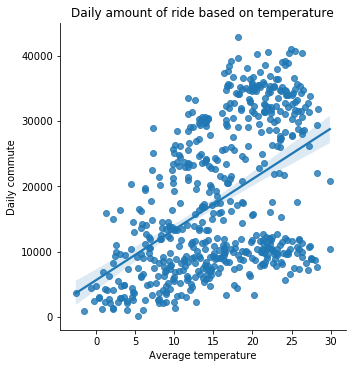

In [100]:
sns.lmplot(data=df, x="mean_temp", y="count")
plt.xlabel('Average temperature')
plt.ylabel('Daily rides')
plt.title('Daily amount of ride based on temperature')

print('The correlation between temperature and BIXI usage is of {}'.format(round(df['mean_temp'].corr(df['count']),3)))

In this graph we clearly see that something is happenning with the data. Around the aure of 15+ we see two different path. My first intuition is that the year 2020, the first summer since COVID, even with higher temperature, people were more doubtful in using shared bike (e.g. you don't know you touch the bike). 

The correlation between temperature and BIXI usage in 2018-2019 is of 0.708
The correlation between temperature and BIXI usage is in 2020 is of 0.756


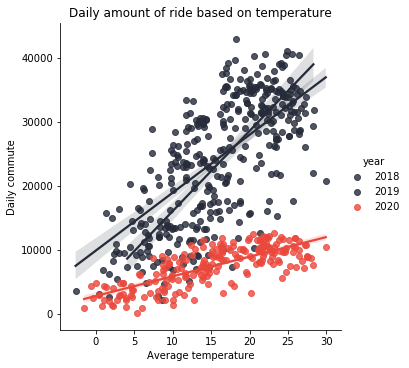

In [108]:
# Adding year as colour in the graph
sns.lmplot(data=df, x="mean_temp", y="count", hue='year', palette=['#252b39', '#252b39', '#eb483c'])
plt.xlabel('Average temperature')
plt.ylabel('Daily rides')
plt.title('Daily amount of ride based on temperature')

df_2019 = df.loc[df['year'] !=2020]
df_2020 = df.loc[df['year'] ==2020]
                 
print('The correlation between temperature and BIXI usage in 2018-2019 is of {}'.format(round(df_2019['mean_temp'].corr(df_2019['count']),3)))
print('The correlation between temperature and BIXI usage is in 2020 is of {}'.format(round(df_2020['mean_temp'].corr(df_2020['count']),3)))

As thought prior, the year 2020 has way less rides than previous years (2018 and 2019). It is interesting to denote that even if there is less rides in 2020 the correlation is strong between the temperature and the how many rides were completed in a day. 